## Walking catchment analysis for proposed Wimbo Park light rail stop
These maps are heavily based on OSMNx and Geoff Boeing's example here:
https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb

This notebook has some additional features:
- function to create isochrones from multiple points and merge them.
- map legend.

In [14]:
#!/usr/bin/env python
# coding: utf-8

#get_ipython().run_line_magic('load_ext', 'autoreload')
#get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import osmnx as ox
import math
import networkx as nx
import sys
import matplotlib.pyplot as plt
import matplotlib_scalebar 
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from descartes import PolygonPatch

# Choose a projected CRS to be used for all distance calculations.
proj_crs = "EPSG:7856"

In [3]:
# This bounding box covers the Surry Hills area inclusive of Central & Moore Park light rail stops.
bbox = (-33.88009802051814, -33.89812417450855, 151.22546367360314, 151.2071817368891)

In [4]:
# importing the network unsimplified so that I can more easily add a certain edge (that is not between intersection nodes) later.
G_wgs = ox.graph_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], network_type='all',
                       simplify=False)

In [5]:
# Downloading existing light rail stop locations from OSM.
tags = {'light_rail':'yes'}
light_rail_stops = ox.geometries_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], tags)
stops = light_rail_stops.loc["node"]   # filtering to nodes as opposed to ways

In [7]:
# finding the closest nodes in the pedestrian network
light_rail_nodes = ox.distance.nearest_nodes(G_wgs, stops.geometry.x, stops.geometry.y)

In [8]:
# to make existing surry hills stop access more accurate, move one access point to other side of the light rail
light_rail_nodes[1] = 1670545963

The best information I can find is that 'the junction of Devonshire and Bourke St' is where the futureproofing was done for the possible stop. I chose two OpenStreetMap nodes representing the closest likely pedestrian access points at this junction. In reality all these stations should be represented by at least 4 points, as the trams are 67 metres long and platforms are generally accessible from both ends, and the middle, but for convenience they are all just represented by two points.

In [9]:
new_access_nodes = [6594058330, 2699055985]

In [10]:
# manually adding one missing footpath between existing Surry Hills stop and a housing estate to the SW
new = G_wgs.add_edge(8930123541, 2548384020, length=55, oneway=False)

### Adding trip times to the graph

In [11]:
trip_times = [5, 10, 15]  # in minutes
times_3 = [3, 6, 9, 12, 15]  # in minutes
walk_speed = 4.5  # walking speed in km/hour
cycle_speed = 15 # cycle speed in km/hr

In [12]:
G = ox.project_graph(G_wgs,to_crs=proj_crs)

In [13]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = walk_speed * 1000 / 60  # km per hour to m per minute
meters_per_minute_cycle = cycle_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time_walk"] = data["length"] / meters_per_minute
    data["time_cycle"] = data["length"] / meters_per_minute_cycle

### Plot preparation

In [15]:
def make_iso_polys(G, timeslist, start_node, edge_buff=25, node_buff=50, infill=False, time="time"):
    isochrone_polys = []
    for trip_time in sorted(timeslist, reverse=True):
        reachable_graph = nx.ego_graph(G, start_node, radius=trip_time, distance=time)

        node_points = [Point((data["x"], data["y"])) for node, data in reachable_graph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(reachable_graph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in reachable_graph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            # the try-except is a kludge because we have some repeated edges in the combined cyclable graph
            # so some edges don't have key 0. but we can ignore these edges as they are repeated anyway
            try:
                edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
                edge_lines.append(edge_lookup)
            except:
                next

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [16]:
def multiple_polys(G, timeslist, start_nodes, edge_buff=25, node_buff=50, infill=False, time="time"):
    all_polys = gpd.GeoDataFrame()
    n = len(timeslist)
    for node in start_nodes:
        polys = make_iso_polys(G, timeslist, node, edge_buff=25, node_buff=0, infill=True, time=time)
        all_polys = pd.concat([all_polys, gpd.GeoDataFrame({'geometry':polys, 'times':timeslist}, crs=proj_crs)])
    return all_polys.dissolve(by='times')

In [17]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(times_3[0:3]), cmap="Greens", start=0, return_hex=True)

For existing stations, choose one out of each platform pair for annotation of the maps.

In [18]:
plot_stops = stops.iloc[np.r_[0:1,2:4]].to_crs(proj_crs)

In [19]:
plot_stops

,light_rail,name,network,operator,public_transport,railway,ref,geometry,shelter,nodes,...,description,foot,horse,indoor,motor_vehicle,surface,wheelchair,wikipedia,opening_date,station
osmid,,,,,,,,,,,,,,,,,,,,,
6172852461,yes,Moore Park,Sydney Light Rail,Transdev,stop_position,stop,5,POINT (335559.453 6248244.888),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6175181708,yes,Surry Hills,NaN,NaN,stop_position,stop,NaN,POINT (334637.749 6248819.178),yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6914569337,yes,Central Chalmers Street,NaN,NaN,stop_position,stop,NaN,POINT (334229.344 6249209.490),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
polygons = multiple_polys(G, times_3[0:3], light_rail_nodes, edge_buff=25, node_buff=0, infill=True, time="time_walk")

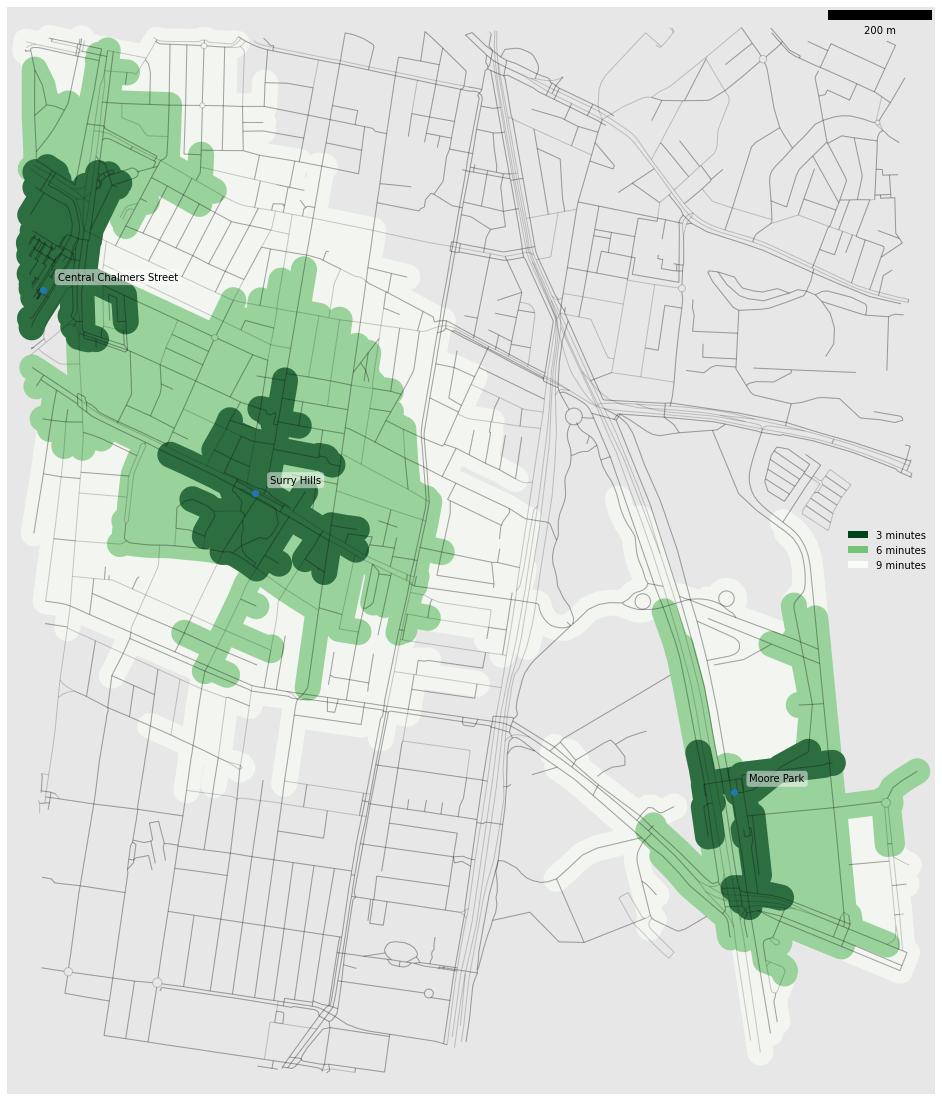

In [25]:
%%capture --no-display
#hides deprecation warnings related to Shapely and patch plotting. Turn off if something is not working.

fig, ax = ox.plot_graph(
    G, bgcolor='#e7e7e7',
    show=False, close=False, 
    edge_color="#111111", edge_alpha=0.2, node_size=0,
    figsize=(20,20)
)

for polygon, fc in zip(polygons.geometry, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
    
legend_elements = [Patch(fc=c, ec="none", label=" ".join([str(time),"minutes"])) 
                   for time, c in zip(times_3[0:3], reversed(iso_colors))]
    
ax.add_artist(ScaleBar(1, frameon=False, length_fraction=0.25))

plot_stops.plot(ax=ax)
plot_stops.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0],
                                       textcoords='offset points', xytext=(15,10), ha='left',
                                       bbox=dict(boxstyle="round", facecolor='white', 
                                       edgecolor="none",alpha=0.5)),
                 axis=1)

ax.legend(handles=legend_elements, loc="right", framealpha=0)
    
plt.show()

In [26]:
new_polygons = multiple_polys(G, times_3[0:3], light_rail_nodes + new_access_nodes, edge_buff=25, node_buff=0, infill=True, time="time_walk")

In [28]:
# for annotation purposes, anchor new stop name to one of the access points chosen earlier
new_stop = gpd.GeoDataFrame(pd.DataFrame(), 
                            geometry=gpd.points_from_xy([G.nodes[new_access_nodes[0]]['x']], [G.nodes[new_access_nodes[0]]['y']]), 
                            crs=proj_crs)
new_stop['name']="Wimbo Park"

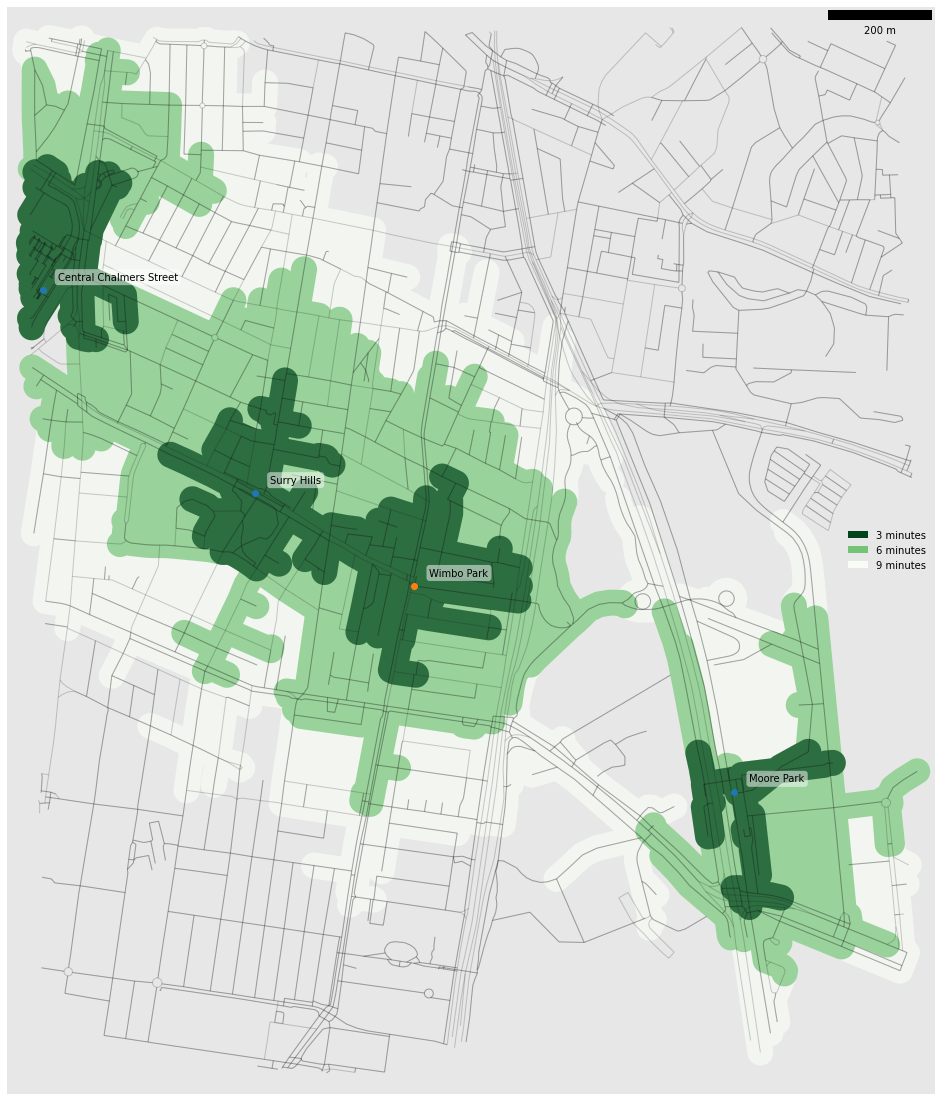

In [29]:
%%capture --no-display
#hides deprecation warnings related to Shapely and patch plotting. Turn off if something is not working.

fig, ax = ox.plot_graph(
    G, bgcolor='#e7e7e7',
    show=False, close=False, 
    edge_color="#111111", edge_alpha=0.2, node_size=0,
    figsize=(20,20)
)

for polygon, fc in zip(new_polygons.geometry, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
    
legend_elements = [Patch(fc=c, ec="none", label=" ".join([str(time),"minutes"])) 
                   for time, c in zip(times_3[0:3], reversed(iso_colors))]
    
ax.add_artist(ScaleBar(1, frameon=False, length_fraction=0.25))

plot_stops.plot(ax=ax)
plot_stops.apply(lambda x: ax.annotate(text=x['name'],
                                       xy=x.geometry.centroid.coords[0],
                                       textcoords='offset points',
                                       xytext=(15,10),
                                       ha='left',
                                       bbox=dict(boxstyle="round", facecolor='white', edgecolor="none",alpha=0.5)),
                 axis=1)

new_stop.plot(ax=ax)
new_stop.apply(lambda x: ax.annotate(text=x['name'],
                                       xy=x.geometry.centroid.coords[0],
                                       textcoords='offset points',
                                       xytext=(15,10),
                                       ha='left',
                                       bbox=dict(boxstyle="round", facecolor='white', edgecolor="none",alpha=0.5)),
                 axis=1)


ax.legend(handles=legend_elements, loc="right", framealpha=0)
    
plt.show()